# Taxi Travel Time Prediction Notebook

### Loading libraries, datasets

In [142]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import holidays

In [143]:
# These are all of the files you are given
df_tr = pd.read_csv("archive/train.csv")

In [144]:
df_tr.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[..."
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[..."
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-..."
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[..."
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-..."


In [145]:
df_tr.shape

(1710670, 9)

### Get Computed Time from POLYLINE

Our goal is to predict the travel-time of the taxi, which can be derived from the POLYLINE length.

Recall:

```
The travel time of the trip (the prediction target of this project) is defined as the (number of points-1) x 15 seconds. 
For example, a trip with 101 data points in POLYLINE has a length of (101-1) * 15 = 1500 seconds. Some trips have missing 
data points in POLYLINE, indicated by MISSING_DATA column, and it is part of the challenge how you utilize this knowledge.
```

We are not doing anything with the MISSING_DATA. It is up to you to find a way to use (or ignore) that information.

In [146]:
# Over every single 
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
df_tr["LEN"] = df_tr["POLYLINE"].apply(polyline_to_trip_duration)

In [147]:
Portugal_holidays = holidays.PT()
def parse_time(x):
    # We are using python's builtin datetime library
    # https://docs.python.org/3/library/datetime.html#datetime.date.fromtimestamp

    # Each x is essentially a 1 row, 1 column pandas Series
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    is_holiday = datetime(dt.year, dt.month, dt.day) in Portugal_holidays
    day_before_holiday = False
    try:
        day_before_holiday = datetime(dt.year, dt.month, dt.day + 1) in Portugal_holidays
    except:
        pass
    else:
        day_before_holiday = datetime(dt.year, dt.month, dt.day + 1) in Portugal_holidays

    return dt.year, dt.month, dt.day, dt.hour, dt.weekday(), is_holiday, day_before_holiday

# Because we are assigning multiple values at a time, we need to "expand" our computed (year, month, day, hour, weekday) tuples on 
# the column axis, or axis 1
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.apply.html
df_tr[["YR", "MON", "DAY", "HR", "WK", "is_holiday", "day_before_holiday"]] = df_tr[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [148]:
df_tr.head(5)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
0,1372636858620000589,C,NaN,NaN,20000589,1372636858,A,False,"[[-8.618643,41.141412],[-8.618499,41.141376],[...",330,2013,6,30,17,6,False,False
1,1372637303620000596,B,NaN,7.0,20000596,1372637303,A,False,"[[-8.639847,41.159826],[-8.640351,41.159871],[...",270,2013,6,30,17,6,False,False
2,1372636951620000320,C,NaN,NaN,20000320,1372636951,A,False,"[[-8.612964,41.140359],[-8.613378,41.14035],[-...",960,2013,6,30,17,6,False,False
3,1372636854620000520,C,NaN,NaN,20000520,1372636854,A,False,"[[-8.574678,41.151951],[-8.574705,41.151942],[...",630,2013,6,30,17,6,False,False
4,1372637091620000337,C,NaN,NaN,20000337,1372637091,A,False,"[[-8.645994,41.18049],[-8.645949,41.180517],[-...",420,2013,6,30,17,6,False,False


In [149]:
df_tr[df_tr['POLYLINE'] == '[]'].head(10)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
762,1372665673620000353,C,NaN,NaN,20000353,1372665673,A,False,[],0,2013,7,1,1,0,False,False
1161,1372669158620000562,C,NaN,NaN,20000562,1372669158,A,False,[],0,2013,7,1,1,0,False,False
1459,1372665875620000496,C,NaN,NaN,20000496,1372665875,A,False,[],0,2013,7,1,1,0,False,False
1677,1372667320620000288,C,NaN,NaN,20000288,1372667320,A,False,[],0,2013,7,1,1,0,False,False
1719,1372676112620000600,C,NaN,NaN,20000600,1372676112,A,False,[],0,2013,7,1,3,0,False,False
1946,1372679607620000080,C,NaN,NaN,20000080,1372679607,A,False,[],0,2013,7,1,4,0,False,False
2468,1372679017620000118,A,11499.0,NaN,20000118,1372679017,A,False,[],0,2013,7,1,4,0,False,False
2789,1372689298620000901,C,NaN,NaN,20000901,1372689298,A,False,[],0,2013,7,1,7,0,False,False
2893,1372691354620000021,B,NaN,10.0,20000021,1372691354,A,False,[],0,2013,7,1,8,0,False,False
3036,1372692506620000981,C,NaN,NaN,20000981,1372692506,A,False,[],0,2013,7,1,8,0,False,False


In [150]:
df_tr[df_tr['MISSING_DATA'] == True].head(10)

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,POLYLINE,LEN,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
105621,1374554455620000625,B,NaN,23.0,20000625,1374554455,A,True,"[[-8.612559,41.145975],[-8.612577,41.145975],[...",630,2013,7,22,21,0,False,False
171397,1375863510620000454,B,NaN,62.0,20000454,1375863510,A,True,"[[-0.205893,41.010282]]",0,2013,8,7,1,2,False,False
299137,1378544246620000057,B,NaN,55.0,20000057,1378544246,A,True,"[[-8.569719,41.166135],[-8.567928,41.166477],[...",150,2013,9,7,1,5,False,False
457486,1381233613620000387,C,NaN,NaN,20000387,1381233613,A,True,"[[-8.626347,41.153436],[-8.626275,41.152905],[...",7230,2013,10,8,5,1,False,False
738466,1386346894620000904,C,NaN,NaN,20000904,1386346894,A,True,"[[-8.652816,40.636575],[-8.652807,40.636566],[...",4260,2013,12,6,8,4,False,False
782321,1387137779620000640,C,NaN,NaN,20000640,1387137779,A,True,"[[-8.604558,41.161941],[-8.604477,41.162013],[...",750,2013,12,15,12,6,False,False
848552,1388351478620000678,A,9738.0,NaN,20000678,1388351478,A,True,"[[-8.609697,41.160276],[-8.609571,41.16033],[-...",390,2013,12,29,13,6,False,False
932391,1390005983620000640,C,NaN,NaN,20000640,1390005983,A,True,"[[-8.604792,41.16123],[-8.604801,41.161167],[-...",195,2014,1,17,16,4,False,False
1275934,1396631707620000163,C,NaN,NaN,20000163,1396631707,A,True,"[[-10.634022,43.834248]]",0,2014,4,4,10,4,False,False
1432196,1399405185620000508,C,NaN,NaN,20000508,1399405185,A,True,"[[-8.620011,41.14683],[-8.619957,41.146659],[-...",780,2014,5,6,12,1,False,False


In [151]:
test = pd.read_csv("archive/test_public.csv")
test[["YR", "MON", "DAY", "HR", "WK", "is_holiday", "day_before_holiday"]] = test[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")

In [152]:
test.head()

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
0,T1,B,NaN,15.0,20000542,1408039037,A,False,2014,8,14,10,3,False,True
1,T2,B,NaN,57.0,20000108,1408038611,A,False,2014,8,14,10,3,False,True
2,T3,B,NaN,15.0,20000370,1408038568,A,False,2014,8,14,10,3,False,True
3,T4,B,NaN,53.0,20000492,1408039090,A,False,2014,8,14,10,3,False,True
4,T5,B,NaN,18.0,20000621,1408039177,A,False,2014,8,14,10,3,False,True


In [153]:
df_tr.drop(df_tr[df_tr['POLYLINE'] == '[]'].index, inplace = True)

In [154]:
df_tr.drop(df_tr[df_tr['MISSING_DATA'] == True].index, inplace = True)
test.drop(test[test['MISSING_DATA'] == True].index, inplace = True)

In [155]:
df_tr = df_tr.drop(columns = ['TIMESTAMP', 'POLYLINE', 'TRIP_ID', 'MISSING_DATA', 'TAXI_ID', 'DAY_TYPE'])
test = test.drop(columns = ['TIMESTAMP', 'TRIP_ID', 'MISSING_DATA', 'TAXI_ID', 'DAY_TYPE'])

In [156]:
df_tr.shape

(1704759, 11)

In [157]:
test.head(10)

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
0,B,NaN,15.0,2014,8,14,10,3,False,True
1,B,NaN,57.0,2014,8,14,10,3,False,True
2,B,NaN,15.0,2014,8,14,10,3,False,True
3,B,NaN,53.0,2014,8,14,10,3,False,True
4,B,NaN,18.0,2014,8,14,10,3,False,True
5,A,42612.0,NaN,2014,8,14,10,3,False,True
6,B,NaN,15.0,2014,8,14,10,3,False,True
7,A,31780.0,NaN,2014,8,14,10,3,False,True
8,B,NaN,9.0,2014,8,14,10,3,False,True
9,B,NaN,15.0,2014,8,14,10,3,False,True


In [158]:
df_tr.head(10)

,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,LEN,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday
0,C,NaN,NaN,330,2013,6,30,17,6,False,False
1,B,NaN,7.0,270,2013,6,30,17,6,False,False
2,C,NaN,NaN,960,2013,6,30,17,6,False,False
3,C,NaN,NaN,630,2013,6,30,17,6,False,False
4,C,NaN,NaN,420,2013,6,30,17,6,False,False
5,C,NaN,NaN,375,2013,6,30,17,6,False,False
6,C,NaN,NaN,525,2013,6,30,17,6,False,False
7,C,NaN,NaN,495,2013,6,30,17,6,False,False
8,C,NaN,NaN,555,2013,6,30,17,6,False,False
9,C,NaN,NaN,270,2013,6,30,17,6,False,False


In [159]:
df_processed = df_tr.copy(deep = True)
test_processed = test.copy(deep = True)

In [160]:
one_hot = pd.get_dummies(df_processed['CALL_TYPE'])
df_processed = df_processed.drop('CALL_TYPE',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test['CALL_TYPE'])
test_processed = test_processed.drop('CALL_TYPE',axis = 1)
test_processed = test_processed.join(one_hot2)

In [161]:
for x in range(12):
    test_processed.loc[len(test_processed.index)] = [0,0,0,x+1,0,0,0,0,0,0,0,0] 

for x in range(31):
    test_processed.loc[len(test_processed.index)] = [0,0,0,0,x+1,0,0,0,0,0,0,0]

for x in range(24):
    test_processed.loc[len(test_processed.index)] = [0,0,0,0,0,x,0,0,0,0,0,0]

for x in range(7):
    test_processed.loc[len(test_processed.index)] = [0,0,0,0,0,0,x,0,0,0,0,0]

test_processed.loc[len(test_processed.index)] = [0,0,0,0,0,0,0,2013,0,0,0,0]

In [162]:
test_processed.head()

,ORIGIN_CALL,ORIGIN_STAND,YR,MON,DAY,HR,WK,is_holiday,day_before_holiday,A,B,C
0,NaN,15.0,2014,8,14,10,3,0,1,0,1,0
1,NaN,57.0,2014,8,14,10,3,0,1,0,1,0
2,NaN,15.0,2014,8,14,10,3,0,1,0,1,0
3,NaN,53.0,2014,8,14,10,3,0,1,0,1,0
4,NaN,18.0,2014,8,14,10,3,0,1,0,1,0


In [163]:
one_hot = pd.get_dummies(df_processed['MON'], prefix= 'Month')
df_processed = df_processed.drop('MON',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test_processed['MON'], prefix= 'Month')
test_processed = test_processed.drop('MON',axis = 1)
test_processed = test_processed.join(one_hot2)

In [164]:
test_processed.head()

,ORIGIN_CALL,ORIGIN_STAND,YR,DAY,HR,WK,is_holiday,day_before_holiday,A,B,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,NaN,15.0,2014,14,10,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
1,NaN,57.0,2014,14,10,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
2,NaN,15.0,2014,14,10,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
3,NaN,53.0,2014,14,10,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0
4,NaN,18.0,2014,14,10,3,0,1,0,1,...,0,0,0,0,0,1,0,0,0,0


In [165]:
one_hot = pd.get_dummies(df_processed['DAY'], prefix= 'Day')
df_processed = df_processed.drop('DAY',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test_processed['DAY'], prefix= 'Day')
test_processed = test_processed.drop('DAY',axis = 1)
test_processed = test_processed.join(one_hot2)

In [166]:
one_hot = pd.get_dummies(df_processed['HR'], prefix= 'HR')
df_processed = df_processed.drop('HR',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test_processed['HR'], prefix= 'HR')
test_processed = test_processed.drop('HR',axis = 1)
test_processed = test_processed.join(one_hot2)

In [167]:
one_hot = pd.get_dummies(df_processed['WK'], prefix= 'WK')
df_processed = df_processed.drop('WK',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test_processed['WK'], prefix= 'WK')
test_processed = test_processed.drop('WK',axis = 1)
test_processed = test_processed.join(one_hot2)

In [168]:
one_hot = pd.get_dummies(df_processed['YR'])
df_processed = df_processed.drop('YR',axis = 1)
df_processed = df_processed.join(one_hot)

one_hot2 = pd.get_dummies(test_processed['YR'])
test_processed = test_processed.drop('YR',axis = 1)
test_processed = test_processed.join(one_hot2)

In [169]:
df_processed.fillna(0, inplace = True)

test_processed.fillna(0, inplace = True)

In [170]:
df_processed.head(10)

,ORIGIN_CALL,ORIGIN_STAND,LEN,is_holiday,day_before_holiday,A,B,C,Month_1,Month_2,...,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2013,2014
0,0.0,0.0,330,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0.0,7.0,270,False,False,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
2,0.0,0.0,960,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
3,0.0,0.0,630,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
4,0.0,0.0,420,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
5,0.0,0.0,375,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
6,0.0,0.0,525,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
7,0.0,0.0,495,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
8,0.0,0.0,555,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
9,0.0,0.0,270,False,False,0,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0


In [171]:
test_processed.head(10)

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_0,Month_1,Month_2,...,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,0,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5,42612.0,0.0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
6,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
7,31780.0,0.0,0,1,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
8,0.0,9.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [172]:
test_processed.drop(columns=[0], inplace=True)
test_processed.head()

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_0,Month_1,Month_2,...,HR_22,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [173]:
test_processed.drop(columns=['Month_0'], inplace=True)
test_processed.head()

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_1,Month_2,Month_3,...,HR_22,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1


In [174]:
test_processed.insert(82, 2013, [0]*test_processed.shape[0])
test_processed.head()

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_1,Month_2,Month_3,...,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2013,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


In [175]:
df_processed.is_holiday = df_processed.is_holiday.apply(lambda x: 1 if x else 0)
df_processed.day_before_holiday = df_processed.day_before_holiday.apply(lambda x: 1 if x else 0)

test_processed.is_holiday = test_processed.is_holiday.apply(lambda x: 1 if x else 0)
test_processed.day_before_holiday = test_processed.day_before_holiday.apply(lambda x: 1 if x else 0)

In [68]:
X = df_processed.drop(columns = ['LEN'])
y = df_processed.LEN

In [185]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

c:\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RMSE: 656.8342991230944


c:\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [189]:
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = Ridge()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

c:\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
c:\Python310\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RMSE: 656.8342703552055


In [ ]:
from sklearn.cluster import KMeans

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = KMeans()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = RandomForestClassifier()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Calculating the mean squared error
mse = mean_squared_error(y_test, y_pred)
print("RMSE:", np.sqrt(mse))

In [72]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [73]:
input_size = X_train.shape[1]
hidden_size = 64
output_size = 1
prev_loss = float('inf')
convergence_threshold = 1e-4

model = MLP(input_size, hidden_size, output_size)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())

In [74]:
%%time
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values)
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values)

epochs = 100
batch_size = 128

train_losses = []
valid_losses = []

for epoch in range(epochs):
    
    running_loss = 0.0
    
    for i in range(0, len(X_train), batch_size):
        
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    average_loss = running_loss / len(X_train)
    diff = abs(prev_loss - average_loss)

    with torch.no_grad():
        valid_loss = criterion(model(X_test).squeeze(), y_test)

    train_losses.append((running_loss/batch_size)**0.5)
    valid_losses.append(valid_loss.item()**0.5)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {(running_loss/batch_size)**0.5}, Validation Loss: {valid_loss.item()**0.5}')
        
    if diff < convergence_threshold:
        break

Epoch 5, Loss: 5851.533325314244, Validation Loss: 656.2320711836629
Epoch 10, Loss: 5839.776268950629, Validation Loss: 655.4289149099237
Epoch 15, Loss: 5835.298677191989, Validation Loss: 654.8846988210978
Epoch 20, Loss: 5832.688848778498, Validation Loss: 654.8628196042282
Epoch 25, Loss: 5831.155224488129, Validation Loss: 654.875441400882
Epoch 30, Loss: 5829.804758483228, Validation Loss: 654.816505786163
Epoch 35, Loss: 5828.507705451693, Validation Loss: 654.6918884101132
Epoch 40, Loss: 5826.9466706940775, Validation Loss: 654.609616489095
Epoch 45, Loss: 5825.047910174023, Validation Loss: 654.4293076795996
Epoch 50, Loss: 5823.726585797995, Validation Loss: 654.3520172659362
Epoch 55, Loss: 5822.422372528349, Validation Loss: 654.4038317430607
Epoch 60, Loss: 5821.732621086766, Validation Loss: 654.2886404332571
Epoch 65, Loss: 5821.059849606863, Validation Loss: 654.3555751653684
Epoch 70, Loss: 5820.517716228026, Validation Loss: 654.3598493948112
Epoch 75, Loss: 5819.82

In [75]:
torch.save(model.state_dict(), "model")

In [176]:
test_processed

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_1,Month_2,Month_3,...,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2013,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
391,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
392,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
393,0.0,0.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [78]:
x_test = torch.Tensor(test_processed.values)
print(x_test.shape)
print(X_train.shape)

torch.Size([320, 35])
torch.Size([1193331, 83])


In [177]:
test_processed.drop(columns=["Day_0"], inplace=True)
test_processed.columns

Index([       'ORIGIN_CALL',       'ORIGIN_STAND',         'is_holiday',
       'day_before_holiday',                  'A',                  'B',
                        'C',            'Month_1',            'Month_2',
                  'Month_3',            'Month_4',            'Month_5',
                  'Month_6',            'Month_7',            'Month_8',
                  'Month_9',           'Month_10',           'Month_11',
                 'Month_12',              'Day_1',              'Day_2',
                    'Day_3',              'Day_4',              'Day_5',
                    'Day_6',              'Day_7',              'Day_8',
                    'Day_9',             'Day_10',             'Day_11',
                   'Day_12',             'Day_13',             'Day_14',
                   'Day_15',             'Day_16',             'Day_17',
                   'Day_18',             'Day_19',             'Day_20',
                   'Day_21',             'Day_22', 

In [178]:
test_processed = test_processed.head(320)
test_processed

,ORIGIN_CALL,ORIGIN_STAND,is_holiday,day_before_holiday,A,B,C,Month_1,Month_2,Month_3,...,HR_23,WK_0,WK_1,WK_2,WK_3,WK_4,WK_5,WK_6,2013,2014
0,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0.0,57.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0.0,15.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0.0,53.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,0.0,18.0,0,1,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,70885.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
316,0.0,53.0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
317,0.0,0.0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
318,76232.0,0.0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [182]:
testfile = pd.read_csv('archive/test_public.csv')
testfile

,TRIP_ID,CALL_TYPE,ORIGIN_CALL,ORIGIN_STAND,TAXI_ID,TIMESTAMP,DAY_TYPE,MISSING_DATA
0,T1,B,NaN,15.0,20000542,1408039037,A,False
1,T2,B,NaN,57.0,20000108,1408038611,A,False
2,T3,B,NaN,15.0,20000370,1408038568,A,False
3,T4,B,NaN,53.0,20000492,1408039090,A,False
4,T5,B,NaN,18.0,20000621,1408039177,A,False
...,...,...,...,...,...,...,...,...
315,T323,A,70885.0,NaN,20000430,1419171485,A,False
316,T324,B,NaN,53.0,20000020,1419170802,A,False
317,T325,C,NaN,NaN,20000207,1419172121,A,False
318,T326,A,76232.0,NaN,20000667,1419171980,A,False


In [183]:
x_test = torch.Tensor(test_processed.values)
outputs = model(x_test)
t = np.array([])
final_predictions = pd.DataFrame().assign(
    TRIP_ID= testfile["TRIP_ID"],
    TRAVEL_TIME = outputs.detach().numpy()
    )

final_predictions

,TRIP_ID,TRAVEL_TIME
0,T1,734.533325
1,T2,694.641907
2,T3,734.533325
3,T4,701.050659
4,T5,751.752319
...,...,...
315,T323,684.762878
316,T324,601.352112
317,T325,713.222839
318,T326,689.509644


In [184]:
final_predictions.to_csv("final_predictions.csv", index=None)

In [187]:
x_test = test_processed.values
outputs = model.predict(x_test)
t = np.array([])
final_predictions = pd.DataFrame().assign(
    TRIP_ID= testfile["TRIP_ID"],
    TRAVEL_TIME = outputs
    )

final_predictions

,TRIP_ID,TRAVEL_TIME
0,T1,671.297499
1,T2,629.910283
2,T3,671.297499
3,T4,633.851922
4,T5,668.341270
...,...,...
315,T323,595.824818
316,T324,536.038974
317,T325,714.350777
318,T326,590.191103


In [188]:
final_predictions.to_csv("final_predictions2.csv", index=None)

In [190]:
x_test = test_processed.values
outputs = model.predict(x_test)
t = np.array([])
final_predictions = pd.DataFrame().assign(
    TRIP_ID= testfile["TRIP_ID"],
    TRAVEL_TIME = outputs
    )

final_predictions

,TRIP_ID,TRAVEL_TIME
0,T1,672.218662
1,T2,630.830672
2,T3,672.218662
3,T4,634.772385
4,T5,669.262377
...,...,...
315,T323,596.751004
316,T324,536.964816
317,T325,715.275585
318,T326,591.117286


In [191]:
final_predictions.to_csv("final_predictions3.csv", index=None)

Text(0, 0.5, 'Training Loss')

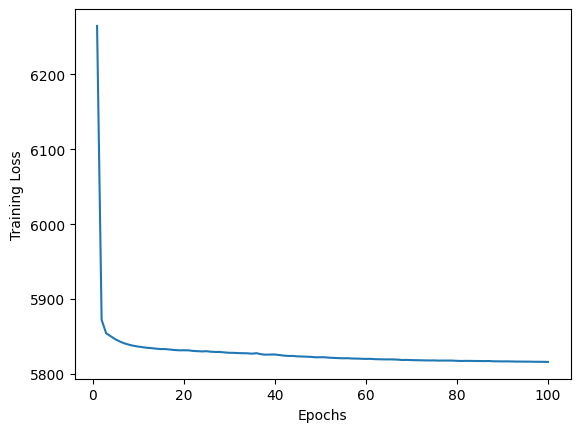

In [30]:
from matplotlib import pyplot as plt

epochs = np.arange(1,101)
plt.plot(epochs, train_losses)
plt.xlabel("Epochs")
plt.ylabel("Training Loss")

Text(0, 0.5, 'RMSE Loss')

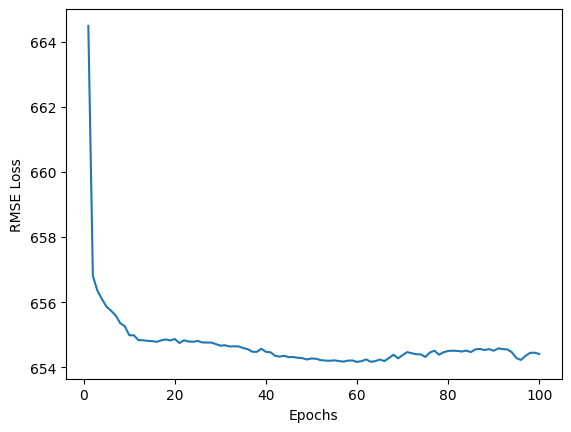

In [31]:
plt.plot(epochs, valid_losses)
plt.xlabel("Epochs")
plt.ylabel("RMSE Loss")

In [52]:
%%time
X_train = torch.Tensor(X_train.values)
y_train = torch.Tensor(y_train.values)
X_test = torch.Tensor(X_test.values)
y_test = torch.Tensor(y_test.values)

epochs = 100
batch_size = 128

for epoch in range(epochs):
    
    running_loss = 0.0
    
    for i in range(0, len(X_train), batch_size):
        
        inputs = X_train[i:i+batch_size]
        labels = y_train[i:i+batch_size]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    average_loss = running_loss / len(X_train)
    diff = abs(prev_loss - average_loss)
    
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}, Loss: {running_loss/len(X_train)}')
        
    if diff < convergence_threshold:
        break

KeyboardInterrupt: 

In [1]:
with torch.no_grad():
    model.eval()
    y_pred = model(X_test)
    test_loss = criterion(y_pred.squeeze(), y_test)
    print(f'Test RMSE: {np.sqrt(test_loss.item())}')

NameError: name 'torch' is not defined

### Create a Prediction File

In [13]:
#from discussion notebook
mean, std = df_tr["LEN"].mean(), df_tr["LEN"].std()
median = df_tr["LEN"].median()
print(f"{mean=} {median=} {std=}")

mean=716.4264615618442 median=600.0 std=684.7511617508213


In [17]:
#from discussion notebook
# Sample submission file that is given on kaggle
df_sample = pd.read_csv("sampleSubmission.csv")

df_sample["TRAVEL_TIME"] = 716.43

# mean(716.43) -> 792.73593
# median(600) -> 784.74219
df_sample.to_csv("my_pred.csv", index=None)

### Do some Feature Analysis

For our feature analysis, we are looking at which of our engineered features may be useful in making a taxicab time regression model

Using: 1692771/1710670


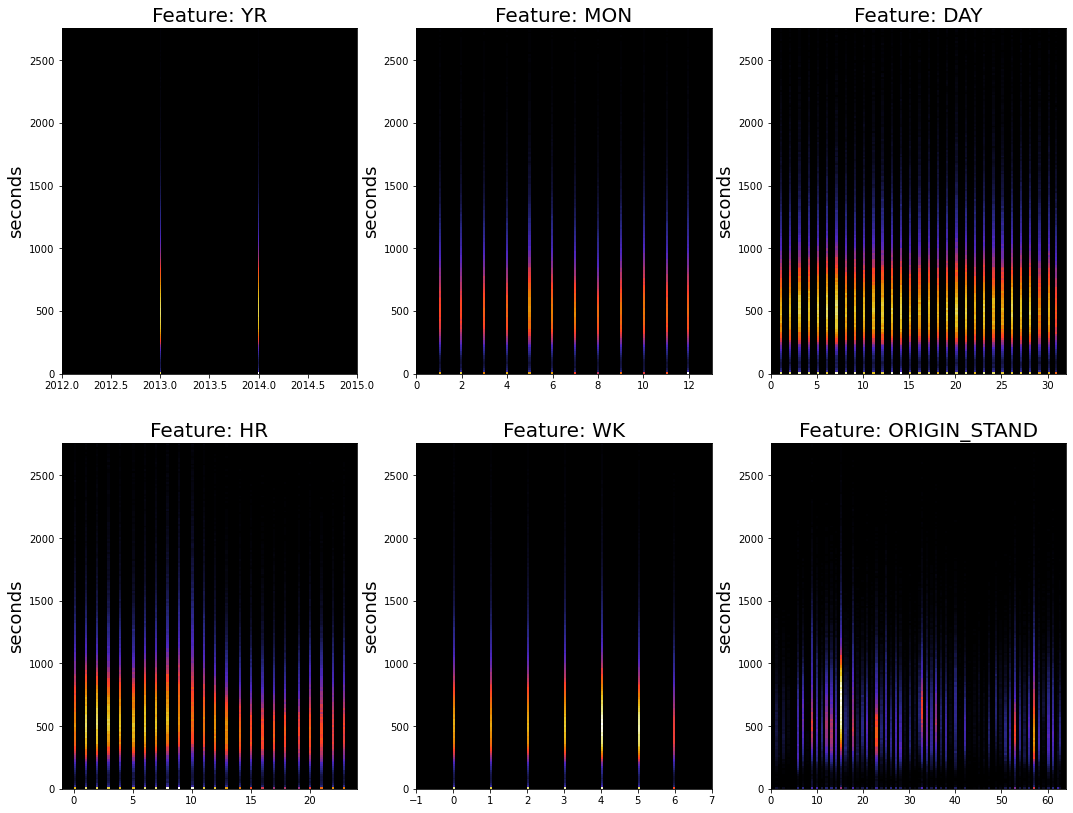

In [15]:
#From the discussion notebook
# First n samples to analyze. Set to -1 to use all data
end = -1

outlier_threshold = 3

# "Choose all data, where the trip length is less than 3 standard deviations away from the mean"
# This is to remove outliers. Otherwise, our plots would look very squished (since there are some
# VERRRRRY long taxi trips in the dataset)
df_trimmed = df_tr[df_tr["LEN"] < mean + outlier_threshold * std]

# Because our y-values only take on multiples of 15, we want just enough buckets in a histogram
# such that each buckets counts one value's frequency. (e.x. one bucket counts how many 15s trips, 
# how many 30s trips, etc. )
buckets = (int(mean + outlier_threshold * std) // 15)

print(f"Using: {len(df_trimmed)}/{len(df_tr)}")

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(18,14))

# Now, we visualize some features that we think might be useful
for idx, v in enumerate(["YR", "MON", "DAY", "HR", "WK", "ORIGIN_STAND"]):
  # idx // 3 = row, idx % 3 = column
  ax = axs[idx // 3, idx % 3]
  
  # Remove any rows with invalid values
  df_subset = df_trimmed.dropna(subset=v)
  
  # Create a histogram. Look up the documentation for more details
  ax.hist2d(df_subset[v][:end], df_subset["LEN"][:end], cmap="CMRmap", bins=(120,buckets))
  
  # Some stylistic things to make the graphs look nice
  ax.set_xlim(ax.get_xlim()[0] - 1, ax.get_xlim()[1] + 1)
  ax.set_facecolor("black")
  ax.set_ylabel("seconds", fontsize=18)
  ax.set_title(f"Feature: {v}", fontsize=20)


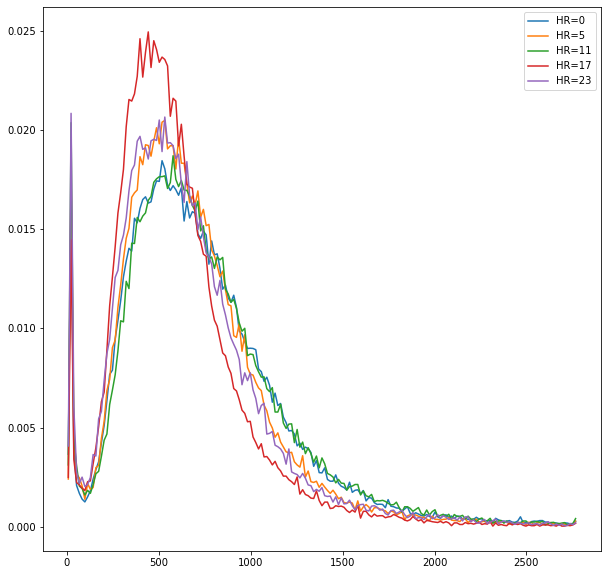

In [9]:
#From the discussion notebook
plt.figure(figsize=(10,10))
for v in [0, 5, 11, 17, 23]:
  # Filter data where the HR matches v
  hourly_data = df_trimmed[df_trimmed["HR"] == v]["LEN"]
  histogram, bin_boundary = np.histogram(hourly_data, bins=buckets)
  histogram = histogram / len(hourly_data)
  # The center is the left_bound and right_bound of a bucket
  bin_centers = [(bin_boundary[i] + bin_boundary[i + 1]) / 2 for i in range(buckets)]
  plt.plot(bin_centers, histogram, label=f"HR={v}")
plt.legend();

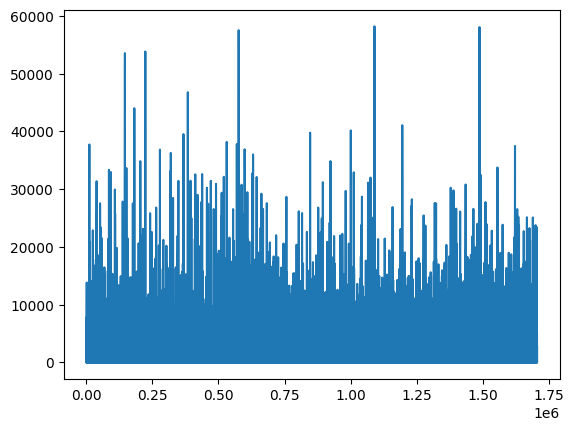

In [192]:
#travel time
travel_time = np.array(df_tr["LEN"])
plt.plot(travel_time)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Month'}, xlabel='MON', ylabel='count'>

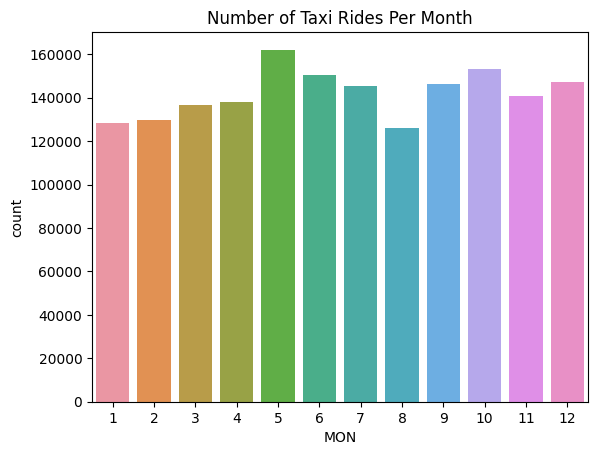

In [193]:
import seaborn

plt.title("Number of Taxi Rides Per Month")
seaborn.countplot(x='MON', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Year'}, xlabel='YR', ylabel='count'>

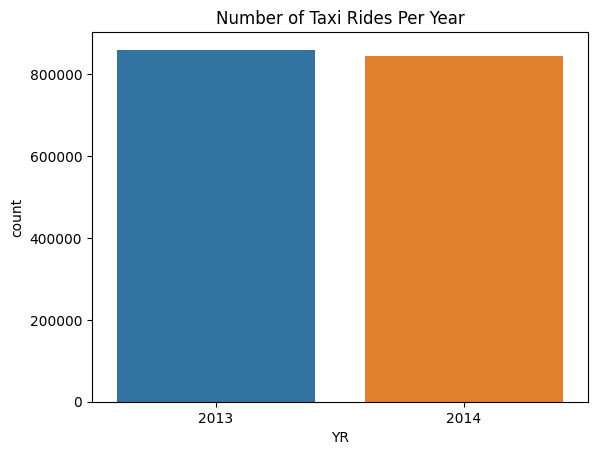

In [194]:
plt.title("Number of Taxi Rides Per Year")
seaborn.countplot(x='YR', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Day'}, xlabel='count', ylabel='DAY'>

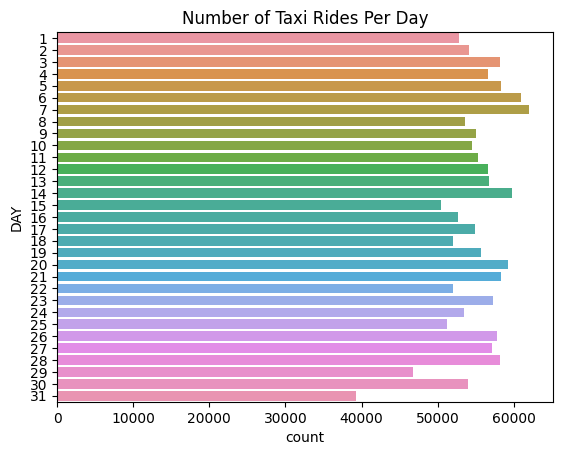

In [195]:
plt.title("Number of Taxi Rides Per Day")
seaborn.countplot(y='DAY', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Hour'}, xlabel='HR', ylabel='count'>

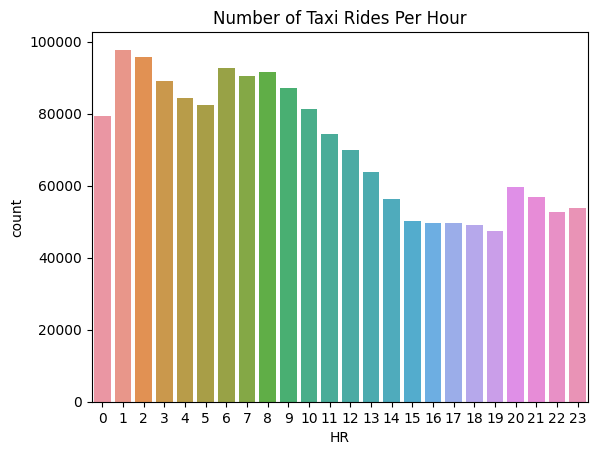

In [196]:
plt.title("Number of Taxi Rides Per Hour")
seaborn.countplot(x='HR', data=df_tr)

<AxesSubplot: title={'center': 'Number of Taxi Rides Per Week'}, xlabel='WK', ylabel='count'>

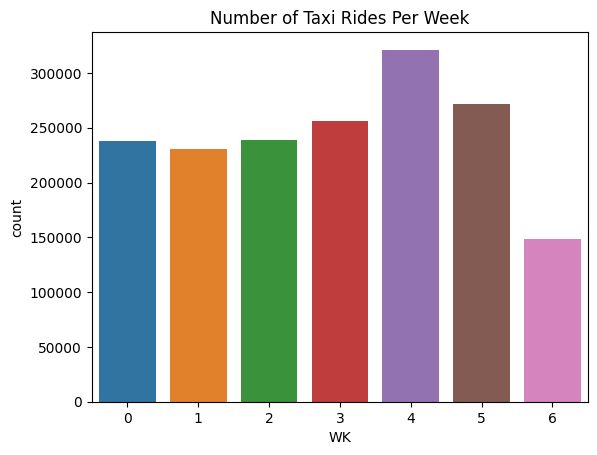

In [197]:
plt.title("Number of Taxi Rides Per Week")
seaborn.countplot(x='WK', data=df_tr)

In [198]:
print("On average, the travel time is: "+ str(df_tr["LEN"].mean()))
print("On average, the number of taxi trips per day is: " + str(df_tr["DAY"].mean()))
print("On average, the number of taxi trips per month is: " + str(df_tr["MON"].mean()))
print("On average, the number of taxi trips per week is: " + str(df_tr["WK"].mean()))

On average, the travel time is: 718.902126341612
On average, the number of taxi trips per day is: 15.728274788401176
On average, the number of taxi trips per month is: 6.603628430763528
On average, the number of taxi trips per week is: 2.938989030120973
